# SITCOM-797

Here is what was requested:

To analyze the positioning system after a slew, create plots for the mirror

- decentering (X and Y)
- mirror tilt (RX, RY, RY)
- piston
- Create a histogram for each parameter for a configurable time period.

Include the limits in all plots:

* the mirror decenters at less than +/- 6 micrometer
* mirror tilt less than +/- 24 e-6 degree
* piston less than +/- 1 micrometer


### Prepare Notebook

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

In [111]:
# Select data from a given date
dayObs = 20230601
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 157 slews and 43 tracks


In [112]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

In [9]:
# select one particular slew event
i_slew = 3

all_columns = ["xPosition", "xRotation", "yPosition", "yRotation", "zPosition", "zRotation"]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

In [10]:
# Get ims data
df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', event=slews[i_slew])
df_ims = df_ims[all_columns]

# Convert meter to milimeter to make is easier to analyse
df_ims[pos_columns] = df_ims[pos_columns] * 1e3

In [11]:
# Get Hard Point states
# We should be careful here as getEfdData may return nothing if we pass the event as an argument. We should pass dayObs instead and check the HP state explicitly
# for the time frame corresponding to the event
df_HPState = getEfdData(client, 'lsst.sal.MTM1M3.logevent_hardpointActuatorState', dayObs = dayObs)

In [107]:
slews[i_slew]

dayObs: 20230601
seqNum: 199
type: SLEWING
endReason: STOPPED
duration: 26.065403938293457
begin: <Time object: scale='tai' format='unix_tai' value=1685620566.6136448>,
end: <Time object: scale='tai' format='unix_tai' value=1685620592.6790488>
beginFloat: 1685620566.6136448
endFloat: 1685620592.6790488


In [108]:
slews[i_slew].duration

26.065403938293457

In [13]:
#Convert begin and end event time to something compatible with pandas
t0 = pd.to_datetime(slews[i_slew].beginFloat, unit="s", utc=True)
t1 = pd.to_datetime(slews[i_slew].endFloat, unit="s", utc=True)

In [14]:
# Find the closest HP state preceding the event begin time 
res = df_HPState.index.get_indexer([t0], method='pad')
t = df_HPState.index[res[0]]

# IF HP is stable then the six motionState values should be equal to 0
#df_HPState[t:t]
HP_global_state = (df_HPState[t:t][[f"motionState{j}" for j in range(6)]] == 0).all(axis=1)
if not HP_global_state.values[0]:
    print("HP is not in a stable state\n", (df_HPState[t:t][[f"motionState{j}" for j in range(6)]] == 0))

In [15]:
# Get elevation and azimuth data
df_ele = getEfdData(client, 'lsst.sal.MTMount.elevation', event= slews[i_slew])
df_azi = getEfdData(client, 'lsst.sal.MTMount.azimuth', event= slews[i_slew])

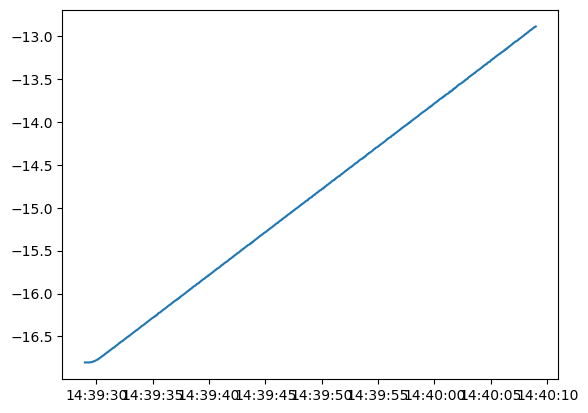

In [16]:
plt.plot(df_azi.index, df_azi['actualPosition'])

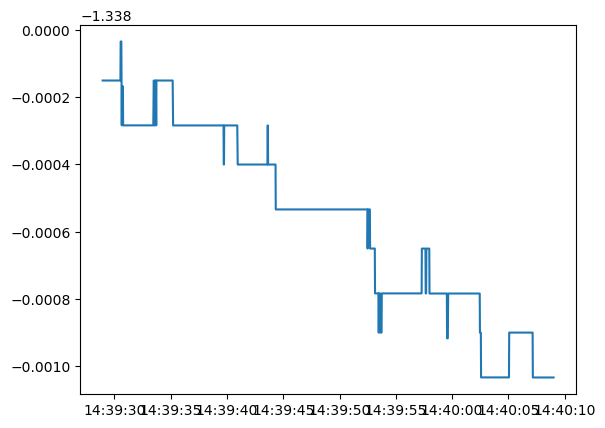

In [17]:
plt.plot(df_ims.index, df_ims["zPosition"])

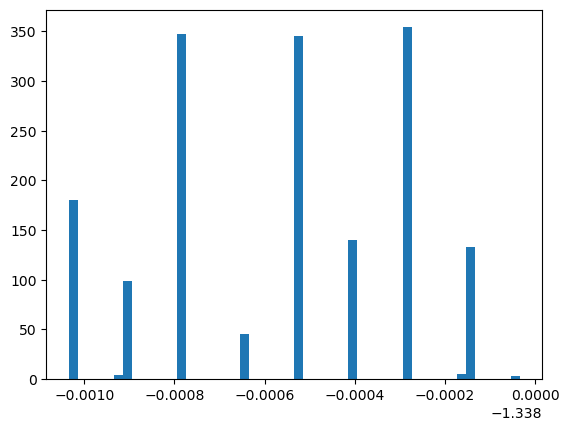

In [18]:
_ = plt.hist(df_ims["zPosition"], bins=50)

In [19]:
df_ele

,actualPosition,actualTorque,actualVelocity,demandPosition,demandVelocity,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,timestamp
2023-05-31 14:39:28.995524+00:00,89.959044,0,-0.000230,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106075,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.031703+00:00,89.959044,0,0.000106,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106076,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.127068+00:00,89.959043,0,0.000124,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106077,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.171917+00:00,89.959044,0,-0.000468,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106078,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.283134+00:00,89.959044,0,-0.000005,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106079,1.685544e+09,1.685544e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 14:40:08.691049+00:00,89.959038,0,0.000146,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106616,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.776855+00:00,89.959037,0,-0.000608,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106617,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.833860+00:00,89.959037,0,0.000079,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106618,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.927341+00:00,89.959037,0,0.000185,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106619,1.685544e+09,1.685544e+09


In [20]:
df_azi

,actualPosition,actualTorque,actualVelocity,demandPosition,demandVelocity,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,timestamp
2023-05-31 14:39:28.994573+00:00,-16.803314,4791.114736,0.000057,-16.803315,0.000000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106316,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.031196+00:00,-16.803315,4940.261597,0.000079,-16.803315,0.000000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106317,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.125866+00:00,-16.803315,5019.668638,0.000246,-16.803315,0.000000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106318,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.171268+00:00,-16.803315,5159.030971,-0.000049,-16.803309,0.000544,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106319,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.282651+00:00,-16.803266,14212.955201,0.001870,-16.802929,0.008300,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106320,1.685544e+09,1.685544e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 14:40:08.690340+00:00,-12.912520,6763.560548,0.099979,-12.900015,0.100000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106857,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.775601+00:00,-12.907519,6769.757349,0.100613,-12.895015,0.100000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106858,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.833360+00:00,-12.897517,6377.324566,0.099762,-12.885015,0.100000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106859,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.926129+00:00,-12.892516,6351.727383,0.100639,-12.880015,0.100000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106860,1.685544e+09,1.685544e+09


In [ ]:
# Loop over all the slews
# Compute mean, sigma and maximum difference w.r.t. the first values
# Store results in a dataframe in order to plot them later
results = pd.DataFrame(columns=["i_slew", "duration", "x_mean", "y_mean", "z_mean", "x_sigma", "y_sigma", "z_sigma", 
                                "R_x_mean", "R_y_mean", "R_z_mean", "Rx_sigma", "Ry_sigma", "Rz_sigma",
                                "dx_max", "dy_max", "dz_max", "R_dx_max", "R_dy_max", "R_dz_max"])

for i_slew, slew in enumerate(slews):
    #print(i_slew)
    # Get ims data
    df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', event=slew)
    if len(df_ims) == 0:
        print(f"No data for slew number: {i_slew}")
        continue      
        
    df_ims = df_ims[all_columns]

    # Convert meter to milimeter to make is easier to analyse
    df_ims[pos_columns] = df_ims[pos_columns] * 1e3
    
    mean = {}
    sigma = {}
    max_diff = {}
    for col in all_columns:
        mean[col] = np.mean(df_ims[col])
        sigma[col] = np.std(df_ims[col])
        t0 = df_ims.index[0]
        max_diff[col] = np.max(np.abs(df_ims[t0:t0][col][0]-df_ims[col]))
        
    # Store computed values in dataframe
    vect = [[i_slew], [slew.duration], [mean[i] for i in pos_columns], [sigma[i] for i in pos_columns], [mean[i] for i in rot_columns], [sigma[i] for i in rot_columns],
            [max_diff[i] for i in pos_columns], [max_diff[i] for i in rot_columns]]
    flat_vect = [item for sublist in vect for item in sublist]
    results = pd.concat([results, pd.DataFrame([flat_vect], columns=results.columns)], ignore_index=True)
        

No data for slew number: 26


No data for slew number: 34


No data for slew number: 36


No data for slew number: 42


No data for slew number: 48


No data for slew number: 51


No data for slew number: 53


No data for slew number: 55


No data for slew number: 56


No data for slew number: 57


No data for slew number: 62


No data for slew number: 66


No data for slew number: 70


No data for slew number: 72


No data for slew number: 76


No data for slew number: 78


No data for slew number: 84


No data for slew number: 94


No data for slew number: 96


No data for slew number: 98


No data for slew number: 102


No data for slew number: 104


No data for slew number: 107


No data for slew number: 109


No data for slew number: 111


No data for slew number: 115


No data for slew number: 117


In [110]:
results

,i_slew,duration,x_mean,y_mean,z_mean,x_sigma,y_sigma,z_sigma,R_x_mean,R_y_mean,R_z_mean,Rx_sigma,Ry_sigma,Rz_sigma,dx_max,dy_max,dz_max,R_dx_max,R_dy_max,R_dz_max
0,0,40.068822,-1.467404,5.576672,-1.328467,0.000015,0.000271,0.000212,-0.002572,-0.014285,0.008268,0.000003,1.553150e-06,1.311492e-06,0.000251,0.000758,0.000634,0.000010,0.000006,0.000009
1,1,40.024595,-1.467441,5.576111,-1.330742,0.000101,0.000099,0.000177,-0.002552,-0.014270,0.008266,0.000002,1.753327e-06,1.347376e-06,0.000256,0.000257,0.000751,0.000007,0.000007,0.000010
2,2,40.086304,-1.467155,5.575862,-1.334827,0.000093,0.000078,0.000183,-0.002525,-0.014239,0.008266,0.000002,8.188962e-07,1.165252e-06,0.000253,0.000252,0.000733,0.000004,0.000004,0.000009
3,3,40.079608,-1.467672,5.576642,-1.338569,0.000117,0.000293,0.000275,-0.002489,-0.014211,0.008271,0.000002,2.119050e-06,1.458198e-06,0.000250,0.000746,0.000884,0.000008,0.000005,0.000007
4,4,42.002171,-1.469667,5.581143,-1.349314,0.000124,0.000177,0.000351,-0.002330,-0.014141,0.008305,0.000005,2.301741e-06,1.666076e-06,0.000252,0.000489,0.001402,0.000019,0.000008,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,151,401.474373,-1.459037,5.552346,-1.341431,0.000170,0.004010,0.005937,-0.002564,-0.014219,0.008271,0.000035,5.034024e-06,2.320354e-06,0.004241,0.013143,0.019471,0.000122,0.000022,0.000019
125,152,201.471889,-1.459184,5.555697,-1.334478,0.000144,0.001342,0.002081,-0.002530,-0.014242,0.008263,0.000013,3.179405e-06,2.486173e-06,0.000744,0.005460,0.007296,0.000046,0.000014,0.000009
126,153,1083.033380,-1.461269,5.565150,-1.325432,0.001520,0.005419,0.005305,-0.002485,-0.014261,0.008269,0.000021,2.058806e-05,3.013652e-06,0.003789,0.017192,0.017959,0.000098,0.000047,0.000016
127,155,60.649852,-1.463472,5.569058,-1.319684,0.000119,0.000596,0.000104,-0.002479,-0.014283,0.008266,0.000002,1.905852e-06,1.185580e-06,0.000253,0.001751,0.000366,0.000007,0.000007,0.000003
